安装所需要的dependencies

In [1]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
import os

import dashscope
from dashscope import TextEmbedding
from dashvector import Client, Doc

import json

from sklearn.metrics.pairwise import cosine_similarity
from dashscope import Generation

import fitz

from pysbd import Segmenter
from tqdm import tqdm


处理pdf文件

In [3]:
import fitz

from pysbd import Segmenter

segmenter = Segmenter()

def read_pdfs_to_list(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with fitz.open(file_path) as doc:
                full_text = ""
                for page in doc:
                    full_text += page.get_text()
                
                full_text = re.sub(r"\n", " ", full_text)
                full_text = re.sub(r"\xa0", " ", full_text)
                full_text = re.sub(r"- ", "", full_text)
                pdf_texts.append(segmenter.segment(full_text.lower()))
    return pdf_texts

folder_path = 'D:\\RexZhann\\nlp\\papers'


pdf_texts = read_pdfs_to_list(folder_path)


处理txt文件

In [26]:
segmenter = Segmenter()

def read_txts_to_list(folder_path):
    txt_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                full_text = file.read()
                
                # 清理文本，替换换行符和非打印字符
                full_text = re.sub(r"\xa0", " ", full_text)
                
                # 去除可能存在的其他不需要的字符或格式
                full_text = re.sub(r"-\n ", "", full_text)
                
                # 使用pysbd进行句子分割
                txt_texts.append(full_text.split('\n\n'))
    return txt_texts

folder_path = 'D:\\RexZhann\\nlp\\papers'

txt_texts = read_txts_to_list(folder_path)


In [27]:
txt_texts = [[re.sub(r"\n", " ", para.lower()) for para in txt_text] for txt_text in txt_texts]
txt_texts

[['f00-f09 organic, including symptomatic, mental disorders',
  'overview of this block',
  "f00 dementia in alzheimer's disease      f00.0 dementia in alzheimer's disease with early onset      f00.1 dementia in alzheimer's disease with late onset      f00.2 dementia in alzheimer's disease, atypical or mixed type      f00.9 dementia in alzheimer's disease, unspecified",
  'f01 vascular dementia      f01.0 vascular dementia of acute onset      f01.1 multi-infarct dementia      f01.2 subcortical vascular dementia      f01.3 mixed cortical and subcortical vascular dementia      f01.8 other vascular dementia      f01.9 vascular dementia, unspecified',
  "f02 dementia in other diseases classified elsewhere      f02.0 dementia in pick's disease      f02.1 dementia in creutzfeldt - jakob disease      f02.2 dementia in huntington's disease      f02.3 dementia in parkinson's disease      f02.4 dementia in human immunodeficiency virus [hiv] disease      f02.8 dementia in other specified diseases

输入关键词

In [29]:
keyword = "dementia in alzheimer's disease"

dep_key = 'diagnostic guidelines'

筛选出相关段落（窗口大小可以自行调整）

In [30]:
def find_related_sent(keyword, sentences):
    related_sent = []
    for sent_per_text in sentences:
        for i, sent in enumerate(sent_per_text):
            if keyword.lower() in sent:
                for j in range(np.max([0, i - 5]), np.min([i + 5, len(sent_per_text)])):
                    if sent_per_text[j] not in related_sent:
                        related_sent.append(sent_per_text[j])
    return related_sent


articles = find_related_sent(keyword, txt_texts)
len(articles)

57

In [31]:
articles

['f00-f09 organic, including symptomatic, mental disorders',
 'overview of this block',
 "f00 dementia in alzheimer's disease      f00.0 dementia in alzheimer's disease with early onset      f00.1 dementia in alzheimer's disease with late onset      f00.2 dementia in alzheimer's disease, atypical or mixed type      f00.9 dementia in alzheimer's disease, unspecified",
 'f01 vascular dementia      f01.0 vascular dementia of acute onset      f01.1 multi-infarct dementia      f01.2 subcortical vascular dementia      f01.3 mixed cortical and subcortical vascular dementia      f01.8 other vascular dementia      f01.9 vascular dementia, unspecified',
 "f02 dementia in other diseases classified elsewhere      f02.0 dementia in pick's disease      f02.1 dementia in creutzfeldt - jakob disease      f02.2 dementia in huntington's disease      f02.3 dementia in parkinson's disease      f02.4 dementia in human immunodeficiency virus [hiv] disease      f02.8 dementia in other specified diseases clas

根据文本长度来决定要不要剪短

In [7]:
articles = articles[30:480]

In [32]:
dashscope.api_key='sk-b8ba4c6e0c9b4e7697fd3cdaaebe63f7'

def generate_embeddings(text):
    rsp = TextEmbedding.call(model=TextEmbedding.Models.text_embedding_v2,
                             input=text)
    embeddings = [record['embedding'] for record in rsp.output['embeddings']]
    return embeddings if isinstance(text, list) else embeddings[0]


In [33]:
def tokenizer_batch(articles, keyword, dep_key, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of tokenizing text based on the deep connection 
            within context and dependency of the text, including extracting out any named entities, possible phrases and chunks of nouns. You are also
            good at recognizing the logical relation between the phrases in one context. The purpose of tokenization is to explore the {dep_key} of {keyword} 
            based on the given paragraphs.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{' '.join(batch)}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible. Be extra careful when a paragraph is likely to contain the {dep_key} of {keyword}
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase.
            '''
            
            rsp = Generation.call(model='qwen-max', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [34]:
res = tokenizer_batch(articles, keyword, dep_key)

phrases_llm = [re.findall(r'"(.*?)"', phrase) for phrase in res]



  0%|          | 0/10 [00:00<?, ?it/s]

Debug: Processing batch 1/10 with 6 phrases


 60%|██████    | 6/10 [00:10<00:07,  1.76s/it]

Debug: Processing batch 2/10 with 6 phrases


12it [00:42,  3.84s/it]                       

Debug: Processing batch 3/10 with 6 phrases


18it [01:07,  3.97s/it]

Debug: Processing batch 4/10 with 6 phrases


24it [01:30,  3.94s/it]

Debug: Processing batch 5/10 with 6 phrases


30it [01:47,  3.52s/it]

Debug: Processing batch 6/10 with 6 phrases


36it [02:06,  3.44s/it]

Debug: Processing batch 7/10 with 6 phrases


42it [02:28,  3.48s/it]

Debug: Processing batch 8/10 with 6 phrases


48it [02:47,  3.38s/it]

Debug: Processing batch 9/10 with 6 phrases


54it [03:11,  3.61s/it]

Debug: Processing batch 10/10 with 3 phrases


57it [03:17,  3.47s/it]


对输出进行处理

In [35]:
import nltk
from nltk.corpus import stopwords
from typing import List

# 获取英文停用词列表，包括连词和介词
stop_words = set(stopwords.words('english'))

phrases_llm = [[phrase for phrase in phrases if len(phrase) <= 30 and len(phrase) > 4 and '%' not in phrase and phrase not in stop_words] for phrases in phrases_llm]
phrases_llm = [phrases for phrases in phrases_llm if len(phrases) != 0]
len(phrases_llm)

10

In [36]:
phrases_llm

[['organic disorders',
  'symptomatic mental disorders',
  'early onset',
  'late onset',
  'atypical or mixed type',
  'unspecified',
  'vascular dementia',
  'acute onset',
  'multi-infarct dementia',
  'subcortical vascular dementia',
  'other vascular dementia',
  'unspecified',
  'dementia in other diseases',
  "Pick's disease",
  'Creutzfeldt-Jakob disease',
  "Huntington's disease",
  "Parkinson's disease",
  'other specified diseases',
  'unspecified dementia'],
 ['a fifth character',
  'dementia',
  'f00-f03',
  'additional symptoms',
  'other symptoms',
  'predominantly delusional',
  'predominantly hallucinatory',
  'predominantly depressive',
  'other mixed symptoms',
  'diagnostic guidelines',
  'primary requirement',
  'diagnosis',
  'evidence',
  'decline',
  'memory',
  'thinking',
  'impair',
  'personal activities',
  'daily living',
  'registration',
  'storage',
  'retrieval',
  'new information',
  'previously learned',
  'familiar material',
  'later stages',
  'd

In [42]:

client = Client(
  api_key='sk-0R9jI2212bV7Ma7u7ba4UmX8QQ8Gt2E2060C14D5411EF9A1EB61E393DC850',
  endpoint='vrs-cn-0mm3ulqnq00032.dashvector.cn-hangzhou.aliyuncs.com'
)


collection = client.get('sample1')
collection.delete(delete_all=True)  #清空collection
assert collection

In [43]:
def batch_generator(items, batchsize):
    for i in range(0, len(items), batchsize):
        yield items[i:i + batchsize]

def process_phrases(phrases_llm, batchsize=6):
    for batch in batch_generator(phrases_llm, batchsize):
        
        for sent in batch:
            embeddings = [generate_embeddings(phrase) for phrase in sent]

            
            docs = [Doc(id=str(len(phrase)), vector=embedding, fields={"title": phrase}) 
                    for phrase, embedding in zip(sent, embeddings)]
        
        rsp = collection.insert(docs)
        assert rsp
process_phrases(phrases_llm, batchsize=5)


In [49]:
rsp = collection.query(generate_embeddings(keyword), output_fields=['title'],topk=30)


related_phrases = [doc.fields['title'] for doc in rsp.output][2:20]
related_phrases_embeddings = [doc.vector for doc in rsp.output][2:20]


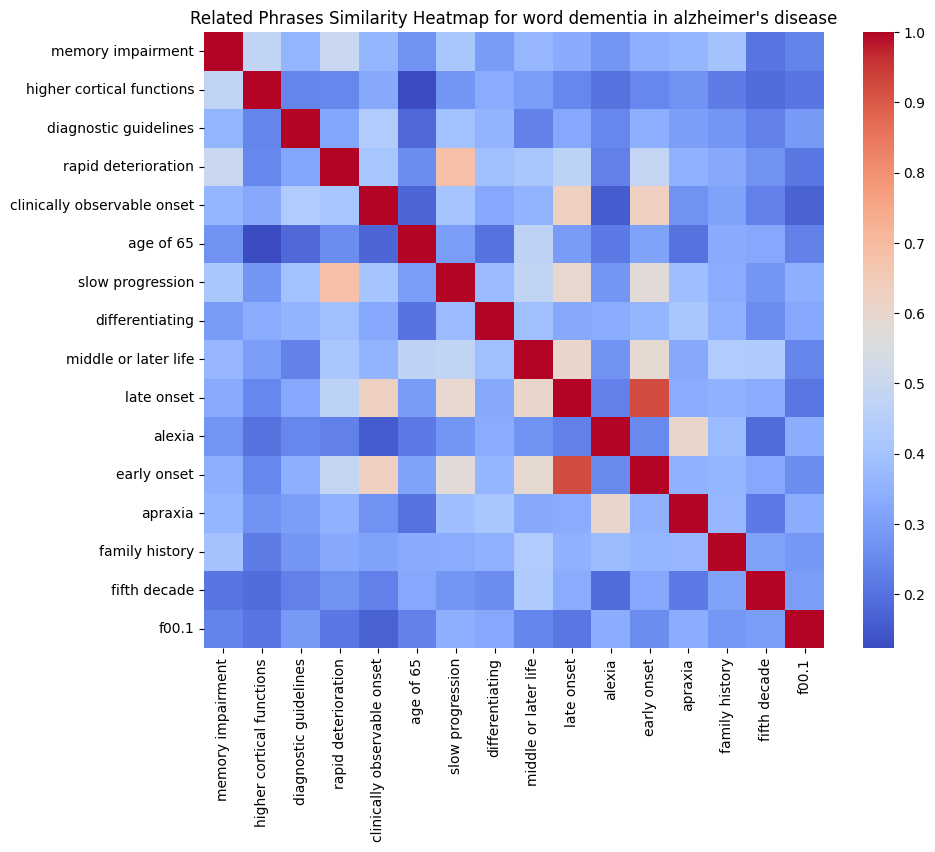

In [50]:
related_phrases_embeddings = [generate_embeddings(phrase) for phrase in related_phrases]

similarity_matrix = cosine_similarity(related_phrases_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=related_phrases, yticklabels=related_phrases, cmap='coolwarm')
plt.title(f'Related Phrases Similarity Heatmap for word {keyword}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

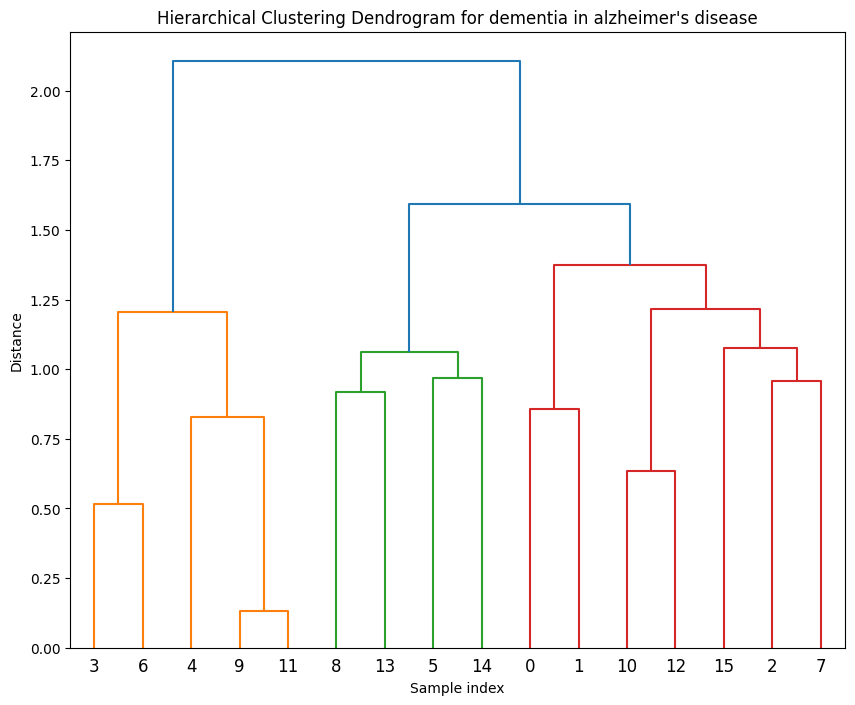

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 层次聚类
Z = linkage(similarity_matrix, 'ward')

# 绘制层次聚类树状图
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title(f'Hierarchical Clustering Dendrogram for {keyword}')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [61]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# 使用相似度矩阵进行层次聚类
Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

# 将短语分为k类
k = 5  # 假设我们要分为5类
clusters = fcluster(Z, k, criterion='maxclust')

def get_representative_phrases( clusters, k, related_phrases, related_phrases_embeddings, target_emb):
    rep_phrases = []
    rep_phrase_emb = []
    
    # 计算target_emb与所有短语嵌入的相似度
    target_similarity = np.dot(related_phrases_embeddings, target_emb)
    
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        
        # 如果当前聚类中没有元素，则跳过
        if not cluster_indices:
            continue
        
        # 计算target_emb与当前聚类中所有短语的相似度
        cluster_similarities = target_similarity[cluster_indices]
        
        # 找出与target_emb最相似的短语索引
        max_similarity_index = np.argmax(cluster_similarities)
        rep_index = cluster_indices[max_similarity_index]
        
        # 添加代表性短语和其嵌入向量
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
        
    return rep_phrases, rep_phrase_emb

final_phrases, final_emb = get_representative_phrases(clusters, k, related_phrases, related_phrases_embeddings, generate_embeddings(keyword))
print(f"Final {k} characteristics of {keyword}:")
for phrase in final_phrases:
    print(phrase)

Final 5 characteristics of dementia in alzheimer's disease:
rapid deterioration
age of 65
memory impairment
alexia
diagnostic guidelines


In [54]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# 使用相似度矩阵进行层次聚类
Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

# 将短语分为k类
k = 5  # 假设我们要分为5类
clusters = fcluster(Z, k, criterion='maxclust')

def get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings):
    rep_phrases = []
    rep_phrase_emb = []
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        cluster_similarity = similarity_matrix[cluster_indices][:, cluster_indices]
        centroid_index = np.argmax(np.sum(cluster_similarity, axis=0))
        rep_index = cluster_indices[centroid_index]
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
    return rep_phrases, rep_phrase_emb

# 获取代表性短语
final_phrases, final_emb = get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings)
print(f"Final {k} average characteristics of {keyword}:")


for phrase in final_phrases:
    print(phrase)


Final 5 average characteristics of dementia in alzheimer's disease:
early onset
middle or later life
memory impairment
alexia
differentiating


In [55]:
def average_dot_product(vectors):
    n = len(vectors)
    dot_products = []

    for i in range(n):
        for j in range(i + 1, n):
            dot_product = np.dot(vectors[i], vectors[j])
            dot_products.append(dot_product)
    
    average_dot = np.mean(dot_products)
    return average_dot

ave_dot = average_dot_product(final_emb)
ave_cos = np.mean(cosine_similarity(final_emb))

print(f'average dot product is {ave_dot}')
print(f'average cosine similarity is {ave_cos}')

average dot product is 0.34641883805222784
average cosine similarity is 0.4771350704417824


In [57]:
def retriever_batch(articles, final_phrases, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an expert at retrieving a phrase from a text database given a list of the characteristics of that phrase.
            # OBJECTIVE #
            Pick exactly one phrase or word from the text database that best fits the list of characteristics.

            list of characteristics: {final_phrases}

            text database: {batch}

            # STYLE #
            output only the result of phrase retrieval. 
            The result could be a single word or a short phrase, but never a sentence. 
            The result must be from the text database.
            Set the temperature parameter to 0 to ensure a precise output
            # RESPONSE #
            do not output anything other than the result of retrieval
            '''
            
            rsp = Generation.call(model='qwen-turbo', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  # 更新进度条
     
    return tokenized_results

In [62]:
retrieval = retriever_batch(articles, final_phrases)

  0%|          | 0/10 [00:00<?, ?it/s]

Debug: Processing batch 1/10 with 6 phrases


 60%|██████    | 6/10 [00:00<00:00, 10.89it/s]

Debug: Processing batch 2/10 with 6 phrases


12it [00:01, 11.79it/s]                       

Debug: Processing batch 3/10 with 6 phrases


18it [00:01, 12.90it/s]

Debug: Processing batch 4/10 with 6 phrases


24it [00:01, 13.38it/s]

Debug: Processing batch 5/10 with 6 phrases


30it [00:02, 13.88it/s]

Debug: Processing batch 6/10 with 6 phrases


36it [00:02, 13.76it/s]

Debug: Processing batch 7/10 with 6 phrases


42it [00:03, 13.73it/s]

Debug: Processing batch 8/10 with 6 phrases


48it [00:03, 13.35it/s]

Debug: Processing batch 9/10 with 6 phrases


54it [00:04, 13.49it/s]

Debug: Processing batch 10/10 with 3 phrases


57it [00:04, 12.66it/s]


In [63]:
len(retrieval)
ave_emb_1 = np.array([generate_embeddings(phrase) for phrase in retrieval])


In [64]:
retrieval_1 = [doc.fields['title'] for doc in collection.query(np.mean(ave_emb_1, axis=0), output_fields=['title'],topk=1).output]
print(f'the retrieval result from the LLMs is : {retrieval_1[0]}')

the retrieval result from the LLMs is : diagnostic guidelines


In [32]:
cate = """

F00 Dementia in Alzheimer's disease
    F00.0 Dementia in Alzheimer's disease with early onset
    F00.1 Dementia in Alzheimer's disease with late onset
    F00.2 Dementia in Alzheimer's disease, atypical or mixed type
    F00.9 Dementia in Alzheimer's disease, unspecified

F01 Vascular dementia
     F01.0 Vascular dementia of acute onset
     F01.1 Multi-infarct dementia
     F01.2 Subcortical vascular dementia
     F01.3 Mixed cortical and subcortical vascular dementia
     F01.8 Other vascular dementia
     FO 1.9 Vascular dementia, unspecified

F02 Dementia in other diseases classified elsewhere
     F02.0 Dementia in Pick's disease
     F02.1 Dementia in Creutzfeldt - Jakob disease
     F02.2 Dementia in Huntington's disease
     F02.3 Dementia in Parkinson's disease
     F02.4 Dementia in human immunodeficiency virus [HIV] disease
     F02.8 Dementia in other specified diseases classified elsewhere

 F03 Unspecified dementia

A fifth character may be added to specify dementia in F00-F03, as follows:
          .xO Without additional symptoms
          .xl Other symptoms, predominantly delusional
          .x2 Other symptoms, predominantly hallucinatory
          .x3 Other symptoms, predominantly depressive
          .x4 Other mixed symptoms

F04 Organic amnesic syndrome, not induced by alcohol and other
    psychoactive substances

F05 Delirium, not induced by alcohol and other psychoactive
    substances
    F05.0 Delirium, not superimposed on dementia, so described
    F05.1 Delirium, superimposed on dementia
    F05.8 Other delirium
    F05.9 Delirium, unspecified

F06 Other mental disorders due to brain damage and dysfunction and
    to physical disease
    F06.0 Organic hallucinosis
    F06.1 Organic catatonic disorder
    F06.2 Organic delusional [schizophrenia-like] disorder
    F06.3 Organic mood [affective] disorders
          .30 Organic manic disorder
          .31 Organic bipolar affective disorder
          .32 Organic depressive disorder
          .33 Organic mixed affective disorder
    F06.4 Organic anxiety disorder
    F06.5 Organic dissociative disorder
    F06.6 Organic emotionally labile [asthenic] disorder
    F06.7 Mild cognitive disorder
    F06.8 Other specified mental disorders due to brain damage and dysfunc-
          tion and to physical disease
     F06.9 Unspecified mental disorder due to brain damage and dysfunction
          and to physical disease

F07 Personality and behavioural disorders due to brain disease, damage
     and dysfunction
    F07.0 Organic personality disorder
     F07.1 Postencephalitic syndrome
     F07.2 Postconcussional syndrome
     F07.8 Other organic personality and behavioural disorders due to brain
          disease, damage and dysfunction
     F07.9 Unspecified organic personality and behavioural disorder due to
          brain disease, damage and dysfunction

F09 Unspecified organic or symptomatic mental disorder
"""

In [33]:
cate

"\n\nF00 Dementia in Alzheimer's disease\n    F00.0 Dementia in Alzheimer's disease with early onset\n    F00.1 Dementia in Alzheimer's disease with late onset\n    F00.2 Dementia in Alzheimer's disease, atypical or mixed type\n    F00.9 Dementia in Alzheimer's disease, unspecified\n\nF01 Vascular dementia\n     F01.0 Vascular dementia of acute onset\n     F01.1 Multi-infarct dementia\n     F01.2 Subcortical vascular dementia\n     F01.3 Mixed cortical and subcortical vascular dementia\n     F01.8 Other vascular dementia\n     FO 1.9 Vascular dementia, unspecified\n\nF02 Dementia in other diseases classified elsewhere\n     F02.0 Dementia in Pick's disease\n     F02.1 Dementia in Creutzfeldt - Jakob disease\n     F02.2 Dementia in Huntington's disease\n     F02.3 Dementia in Parkinson's disease\n     F02.4 Dementia in human immunodeficiency virus [HIV] disease\n     F02.8 Dementia in other specified diseases classified elsewhere\n\n F03 Unspecified dementia\n\nA fifth character may be 

In [42]:
full_text = re.sub(r"\n", " ", cate)
full_text = re.sub(r"\xa0", " ", full_text)
full_text = re.sub(r"- ", "", full_text)
full_text

"  F00 Dementia in Alzheimer's disease     F00.0 Dementia in Alzheimer's disease with early onset     F00.1 Dementia in Alzheimer's disease with late onset     F00.2 Dementia in Alzheimer's disease, atypical or mixed type     F00.9 Dementia in Alzheimer's disease, unspecified  F01 Vascular dementia      F01.0 Vascular dementia of acute onset      F01.1 Multi-infarct dementia      F01.2 Subcortical vascular dementia      F01.3 Mixed cortical and subcortical vascular dementia      F01.8 Other vascular dementia      FO 1.9 Vascular dementia, unspecified  F02 Dementia in other diseases classified elsewhere      F02.0 Dementia in Pick's disease      F02.1 Dementia in Creutzfeldt Jakob disease      F02.2 Dementia in Huntington's disease      F02.3 Dementia in Parkinson's disease      F02.4 Dementia in human immunodeficiency virus [HIV] disease      F02.8 Dementia in other specified diseases classified elsewhere   F03 Unspecified dementia  A fifth character may be added to specify dementia in

In [46]:
def cate_manager(full_text):
    prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of organizing categories of mental and behavioural 
            disorders, you can always manage to convert the given string into classical tree-structure in python dictionary. The given list of 
            categories consists of some major categories of disorders and their corresponding sub-categories. The major categories 
            code style "FXX" where X's are the placeholders of code, while the sub-categories of "FXX" will have code style "FXX.Y", 
            where both X and Y are placeholders.
            # OBJECTIVE #
            organize and convert this list of categories into a python tree:{full_text}
            # STYLE #
            output only the resulted dictionary. It must be a direct data structure, not any raw code. the dictionary will use the code of each category as the key.
            # RESPONSE #
            do not output anything other than the resulted tree. Ignore any page numbers and page titles in the given list.
            '''
    
    rsp = Generation.call(model='qwen-turbo', prompt=prompt)
    return rsp.output.text

In [47]:
dic_cat = cate_manager(full_text)

In [50]:
import json

dic_cat = json.loads(dic_cat)

print(dic_cat)

{'F00': {"Dementia in Alzheimer's disease": {'F00.0': "Dementia in Alzheimer's disease with early onset", 'F00.1': "Dementia in Alzheimer's disease with late onset", 'F00.2': "Dementia in Alzheimer's disease, atypical or mixed type", 'F00.9': "Dementia in Alzheimer's disease, unspecified"}, 'Vascular dementia': {'F01.0': 'Vascular dementia of acute onset', 'F01.1': 'Multi-infarct dementia', 'F01.2': 'Subcortical vascular dementia', 'F01.3': 'Mixed cortical and subcortical vascular dementia', 'F01.8': 'Other vascular dementia', 'F01.9': 'Vascular dementia, unspecified'}, 'Dementia in other diseases classified elsewhere': {'F02.0': "Dementia in Pick's disease", 'F02.1': 'Dementia in Creutzfeldt Jakob disease', 'F02.2': "Dementia in Huntington's disease", 'F02.3': "Dementia in Parkinson's disease", 'F02.4': 'Dementia in human immunodeficiency virus [HIV] disease', 'F02.8': 'Dementia in other specified diseases classified elsewhere', 'F02.9': 'Dementia in other diseases classified elsewher

In [53]:
dic_cat['F00']["Dementia in Alzheimer's disease"]

{'F00.0': "Dementia in Alzheimer's disease with early onset",
 'F00.1': "Dementia in Alzheimer's disease with late onset",
 'F00.2': "Dementia in Alzheimer's disease, atypical or mixed type",
 'F00.9': "Dementia in Alzheimer's disease, unspecified"}

In [ ]:
def cate_manager(cate, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of organizing categories of mental and behavioural 
            disorders, you can always manage to convert the given string into classical tree structured python list.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{cate}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible.
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase.
            '''
            
            rsp = Generation.call(model='qwen-long', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [62]:
txt_texts

[['icd-10        thelcd-10        classification        of mental and        behavioural        disorders         clinical        descriptions        and diagnostic        guidelines         | world health organization       i geneva       i 1992                      reprinted 1993, 1994, 1995, 1998, 2000, 2002, 2004   who library cataloguing in publication data the icd-10 classification of mental and behavioural    disorders : clinical descriptions and diagnostic guidelines.    ',
  '1.mental disorders — classification 2.mental disorders — diagnosis    isbn 92 4 154422 8 (nlm classification: wm 15)                             © world health organization 1992  all rights reserved. ',
  'publications of the world health organization can be obtained from marketing and dissemination, world health organization, 20 avenue appia, 1211 geneva 27, switzerland (tel: +41 22 791 2476; fax: +41 22 791 4857; email: bookorders@who.int). ',
  'requests for permission to reproduce or translate who pub

In [65]:
import re

# 假设这是你的TXT文件路径
file_path = "D:\\RexZhann\\nlp\\papers\\9241544228_eng.pdf"

# 创建一个字典来存储章节文本
chapter_dict = {}

# 正则表达式匹配章节编号，例如 'F00', 'F01' 等
chapter_pattern = re.compile(r'^(f\d{2}-f\d{2})?')

# 初始化变量
current_chapter_key = None
current_chapter_text = []

# 读取文件并处理每一行

for line in txt_texts[0]:
    # 检查当前行是否是新的章节开始
    match = chapter_pattern.search(line)
    if match:
        # 如果已经存在当前章节，保存到字典
        if current_chapter_key:
            chapter_dict[current_chapter_key] = ''.join(current_chapter_text).strip()
        
        # 更新当前章节编号
        current_chapter_key = match.group(1)
        # 重置章节文本列表
        current_chapter_text = [line]
    else:
        # 如果当前行不是新的章节开始，追加到当前章节的文本列表
        if current_chapter_key:
            current_chapter_text.append(line)

# 保存最后一个章节的内容
if current_chapter_key and current_chapter_text:
    chapter_dict[current_chapter_key] = ''.join(current_chapter_text).strip()

# 打印结果查看
for key, text in chapter_dict.items():
    print(f"Chapter {key}: {text[:100]}...")  # 打印每个章节的前100个字符作为示例

Chapter f90-f98: f90-f98 behavioural and emotional disorders with onset usually occurring in childhood and adolescenc...
Chapter f60-f62: f60-f62 specific personality disorders, mixed and other personality disorders, and enduring personal...


In [59]:
chapter_dict

{}

'Diagnostic guidelines\n\ndementia is common (F05.1). The above symptoms and impairments should\nhave been evident for at least 6 months for a confident clinical diagnosis of\ndementia to be made.\n\nDifferential diagnosis. Consider: a depressive disorder (F30-F39), which\nmay exhibit many of the features of an early dementia, especially memory\nimpairment, slowed thinking, and lack of spontaneity; delirium (F05); mild\nor moderate mental retardation (F70-F71); states of subnormal cognitive\nfunctioning attributable to a severely impoverished social environment and\nlimited education; iatrogenic mental disorders due to medication (F06.-).\n\nDementia may follow any other organic mental disorder classified in this block,\nor coexist with some of them, notably delirium (see F05.1).\n\n\n46'